In [1]:
#General stuff
import time
import datetime
import glob
import re
import pandas as pd
from collections import Counter
import progressbar
import jellyfish
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import numpy as np
import statsmodels.formula.api as smf
from collections import Counter
from itertools import chain

## Pulling in all the files

In [2]:
df = pd.read_csv('data/df_final_harm.csv')

## I want to look for repetitions "sozialrechtliche Abteilungen"
And I'm working with the years, as the whole long string consisting of 15'000 verdicts is just too long. The Kernel dies regularly. Which really isn't much fun.

In [4]:
df_sozrecht = df[df['recht_harm'] == 'Zivilrecht']
sozrecht = df_sozrecht[df_sozrecht['Language'] == 'De']['Text-Nummer']

Splitting up the lists.

In [5]:
l = list(sozrecht)
n = 1000
txt_lsts = [l[i:i + n] for i in range(0, len(l), n)]

In [6]:
df_ = pd.DataFrame(columns=['index', 0])
bar = progressbar.ProgressBar()

for txt_lst, i in zip(txt_lsts, bar(range(len(txt_lsts)))):

    long_str = ''
    
    for txt in txt_lst:
    
        file = open('txt_files/' + txt, 'r')
        text = file.read()
        #Making sure the line breaks '/n', 'xa0' and double spaces are removed
        text = text.replace('\n', ' ').replace('\xa0', '').replace('  ', ' ')
        #Removing these automated notifications
        text = text.replace('Wichtiger Hinweis:Diese Website wird in älteren Versionen von Netscape ohne graphische Elemente dargestellt. Die Funktionalität der Website ist aber trotzdem gewährleistet. Wenn Sie diese Website regelmässig benutzen, empfehlen wir Ihnen, auf Ihrem Computer einen aktuellen Browser zu installieren.Zurück zur Einstiegsseite Drucken Grössere Schrift', '')
        text = text.replace('Vorwärts ähnliche Leitentscheide suchenähnliche Urteile ab 2000 suchen Drucken nach oben', '')
        text = text.replace('Bundesgericht Tribunal fédéral Tribunale federale Tribunal federal', '')
        text = text.replace('Navigation Neue Suche Zurück zum Suchresultat Rang: Zurück 180', '')
        text = text.replace('Navigation Neue Suche Zurück zum Suchresultat Rang:1 ähnliche Leitentscheide suchenähnliche Urteile ab 2000 suchen Drucken nach oben', '')
    
        long_str = long_str + text
        
    df_new = pd.DataFrame(pd.Series( long_str[ix:ix+500] for ix in list(range(len(long_str))) ).value_counts()).reset_index()
    df_new = df_new[df_new[0]> 1]
    
    frames = [df_, df_new]
    df_ = pd.concat(frames)
    

 91% (11 of 12) |#######################   | Elapsed Time: 0:08:57 ETA: 0:00:46

# Renaming columns
Later, I can just jump to this step, I don't need to repeat the steps above

In [7]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2588542 entries, 0 to 141499
Data columns (total 2 columns):
index    object
0        float64
dtypes: float64(1), object(1)
memory usage: 59.2+ MB


In [8]:
df_.columns = [['String', 'Count']]

# Deleting Duplicates

In [9]:
df_ = df_.drop_duplicates(subset='String', keep='first')

In [10]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2231122 entries, 0 to 141499
Data columns (total 2 columns):
String    object
Count     float64
dtypes: float64(1), object(1)
memory usage: 51.1+ MB


In [11]:
df = df_[df_['Count'] >= 10]

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22951 entries, 0 to 5741
Data columns (total 2 columns):
String    22951 non-null object
Count     22951 non-null float64
dtypes: float64(1), object(1)
memory usage: 537.9+ KB


# Matching similar Strings
Using Jellyfish and remodelling the original df, using it to create a new list of string. Because these ones are the ones I don't need to consider anymore.

In [13]:
df_new = pd.DataFrame(columns=['String', 'Count', 'Jaro'])

for count in range(1000):
    
    print(count)
    string_list = list(df['String'])
    value_list = []
    bar = progressbar.ProgressBar()

    for elem, i in zip(string_list, bar(range(len(string_list)))):
    
        value = jellyfish.jaro_distance(string_list[0], elem)
        value_list.append(value)
    
    df['Jaro'] = value_list
    df_unique = df[df['Jaro'] >= .825].head(1)

    frames = [df_new, df_unique]
    df_new = pd.concat(frames)

    df = df[df['Jaro'] <= .825]
    del df['Jaro']

  5% (1163 of 22951) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:03

0


 98% (22661 of 22951) |################### | Elapsed Time: 0:00:03 ETA: 0:00:00/Users/barneyjs/.virtualenvs/master/lib/python3.5/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
  5% (1157 of 22834) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

1


  5% (1153 of 22758) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

2


  5% (1151 of 22721) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

3


  5% (1149 of 22681) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

4


  5% (1146 of 22621) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:03

5


  5% (1138 of 22457) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

6


  5% (1132 of 22338) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:03

7


  5% (1129 of 22286) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

8


  5% (1126 of 22233) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

9


  5% (1124 of 22197) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

10


  5% (1123 of 22170) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:03

11


  5% (1113 of 21978) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

12


  3% (830 of 21845) |                      | Elapsed Time: 0:00:00 ETA: 0:00:04

13


  3% (828 of 21781) |                      | Elapsed Time: 0:00:00 ETA: 0:00:04

14


  4% (1075 of 21640) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:03

15


  5% (1093 of 21583) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

16


  5% (1086 of 21448) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:03

17


  5% (1086 of 21435) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:03

18


  5% (1079 of 21296) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:03

19


  3% (808 of 21258) |                      | Elapsed Time: 0:00:00 ETA: 0:00:03

20


  5% (1074 of 21205) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

21


  5% (1071 of 21141) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:03

22


  5% (1067 of 21069) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

23


  5% (1056 of 20851) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

24


  5% (1050 of 20725) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

25


  5% (1042 of 20577) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

26


  5% (1041 of 20550) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

27


  5% (1038 of 20499) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

28


  5% (1036 of 20448) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

29


  5% (1034 of 20406) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

30


  5% (1028 of 20293) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:03

31


  5% (1027 of 20266) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

32


  5% (1025 of 20226) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

33


  5% (1023 of 20197) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

34


  5% (1021 of 20151) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

35


  5% (1021 of 20147) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

36


  5% (1020 of 20143) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:03

37


  5% (1017 of 20073) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:03

38


  5% (1014 of 20007) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:03

39


  5% (1010 of 19942) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

40


  5% (1007 of 19875) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:03

41


  5% (1003 of 19807) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

42


  5% (1002 of 19789) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

43


  5% (999 of 19716) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:03

44


  5% (997 of 19682) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

45


  5% (995 of 19640) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

46


  5% (990 of 19552) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

47


  5% (986 of 19457) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

48


  5% (982 of 19390) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:03

49


  5% (980 of 19354) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

50


  5% (974 of 19219) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

51


  5% (970 of 19142) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

52


  5% (967 of 19084) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

53


  5% (965 of 19049) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

54


  5% (963 of 19010) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

55


  5% (960 of 18955) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

56


  5% (958 of 18911) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

57


  7% (1434 of 18874) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

58


  5% (953 of 18820) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

59


  5% (952 of 18783) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

60


  5% (950 of 18760) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

61


  5% (949 of 18739) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:03

62


  5% (948 of 18723) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

63


  5% (948 of 18716) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

64


  5% (948 of 18712) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

65


  7% (1420 of 18688) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

66


  7% (1417 of 18651) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

67


  5% (942 of 18593) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

68


  5% (942 of 18591) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

69


  5% (942 of 18589) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

70


  5% (942 of 18586) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

71


  5% (937 of 18489) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

72


  5% (932 of 18407) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

73


  5% (929 of 18333) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

74


  7% (1386 of 18242) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

75


  7% (1378 of 18139) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

76


  7% (1373 of 18073) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

77


  5% (913 of 18030) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

78


  7% (1367 of 17994) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

79


  7% (1362 of 17928) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

80


  7% (1357 of 17862) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

81


  7% (1352 of 17792) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

82


  7% (1348 of 17744) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

83


  7% (1344 of 17689) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

84


  7% (1339 of 17622) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

85


  7% (1335 of 17577) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

86


  7% (1330 of 17508) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

87


  7% (1324 of 17428) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

88


  7% (1319 of 17366) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

89


  7% (1315 of 17314) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

90


  7% (1309 of 17227) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

91


  7% (1307 of 17205) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

92


  7% (1304 of 17161) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

93


  7% (1302 of 17141) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

94


  7% (1296 of 17061) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

95


  7% (1293 of 17016) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

96


  7% (1289 of 16971) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

97


  5% (855 of 16883) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

98


  7% (1281 of 16856) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

99


  7% (1275 of 16781) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

100


  7% (1269 of 16708) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

101


  7% (1265 of 16655) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

102


  5% (843 of 16641) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

103


  7% (1261 of 16592) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

104


  7% (1256 of 16529) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

105


  5% (836 of 16496) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

106


  7% (1252 of 16473) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

107


  7% (1249 of 16445) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

108


  7% (1248 of 16419) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

109


  7% (1246 of 16395) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

110


  7% (1243 of 16359) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

111


  7% (1237 of 16283) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

112


  7% (1234 of 16245) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

113


  7% (1231 of 16196) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

114


  7% (1227 of 16153) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

115


  7% (1222 of 16087) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

116


  7% (1220 of 16062) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

117


  7% (1219 of 16050) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

118


  7% (1218 of 16035) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

119


  7% (1215 of 15996) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

120


  7% (1215 of 15990) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

121


  7% (1214 of 15979) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

122


  7% (1213 of 15963) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

123


  7% (1210 of 15928) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

124


  7% (1207 of 15887) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

125


  7% (1204 of 15844) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

126


  5% (802 of 15833) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

127


  7% (1202 of 15825) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

128


  7% (1201 of 15805) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

129


  7% (1200 of 15792) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

130


  7% (1197 of 15754) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

131


  5% (798 of 15750) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

132


  5% (797 of 15732) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

133


  7% (1195 of 15725) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

134


  7% (1191 of 15671) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

135


  7% (1190 of 15664) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

136


  7% (1190 of 15656) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

137


  7% (1189 of 15647) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

138


  7% (1188 of 15640) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

139


  7% (1188 of 15637) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

140


  7% (1188 of 15634) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

141


  7% (1188 of 15632) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

142


  7% (1188 of 15631) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

143


  7% (1183 of 15570) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

144


  7% (1182 of 15563) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

145


  7% (1180 of 15535) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

146


  5% (787 of 15531) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

147


  7% (1174 of 15451) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

148


  7% (1171 of 15415) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

149


  7% (1169 of 15379) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

150


  7% (1165 of 15329) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

151


  7% (1158 of 15236) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

152


  7% (1153 of 15175) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

153


  7% (1149 of 15117) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

154


  7% (1141 of 15021) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

155


  7% (1133 of 14917) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

156


  7% (1130 of 14870) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

157


  7% (1128 of 14840) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

158


  7% (1126 of 14821) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

159


  7% (1125 of 14807) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

160


  7% (1125 of 14800) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

161


  7% (1123 of 14778) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

162


  7% (1122 of 14761) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

163


  7% (1121 of 14751) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

164


  7% (1120 of 14734) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

165


  7% (1118 of 14714) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

166


  7% (1113 of 14648) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

167


  7% (1112 of 14638) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

168


  8% (1297 of 14629) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

169


  7% (1107 of 14572) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

170


  7% (1104 of 14526) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

171


  7% (1102 of 14500) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

172


  7% (1101 of 14487) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

173


  7% (1094 of 14398) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

174


  7% (1091 of 14364) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

175


  7% (1090 of 14350) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

176


  7% (1090 of 14349) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

177


  7% (1090 of 14348) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

178


  7% (1087 of 14309) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

179


  7% (1087 of 14300) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

180


  8% (1267 of 14297) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

181


  7% (1082 of 14237) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

182


  5% (718 of 14180) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

183


  5% (717 of 14158) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

184


  7% (1071 of 14094) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

185


  7% (1070 of 14083) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

186


  7% (1069 of 14069) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

187


  7% (1067 of 14037) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

188


  7% (1063 of 13996) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

189


  7% (1062 of 13976) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

190


  7% (1060 of 13945) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

191


  8% (1233 of 13907) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

192


  8% (1227 of 13842) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

193


  7% (1048 of 13795) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

194


  8% (1221 of 13775) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

195


  8% (1219 of 13751) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

196


  7% (1043 of 13720) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

197


  7% (1041 of 13697) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

198


  7% (1038 of 13662) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

199


  8% (1208 of 13622) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

200


  8% (1205 of 13593) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

201


  7% (1031 of 13570) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

202


  8% (1201 of 13543) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

203


  7% (1027 of 13520) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

204


  7% (1027 of 13518) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

205


  7% (1026 of 13502) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

206


  7% (1024 of 13477) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

207


  8% (1194 of 13470) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

208


  7% (1022 of 13456) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

209


  7% (1022 of 13455) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

210


 10% (1363 of 13451) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

211


  8% (1190 of 13428) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

212


  7% (1020 of 13421) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

213


  7% (1020 of 13417) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

214


  7% (1019 of 13414) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

215


  7% (1019 of 13413) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

216


  7% (1012 of 13317) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

217


  7% (1008 of 13271) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

218


  7% (1005 of 13230) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

219


 10% (1333 of 13157) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

220


  7% (996 of 13102) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

221


 10% (1319 of 13019) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

222


  7% (986 of 12980) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

223


  8% (1148 of 12949) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

224


  8% (1140 of 12865) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

225


  7% (973 of 12799) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

226


  7% (966 of 12716) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

227


  7% (964 of 12683) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

228


  7% (964 of 12682) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

229


  8% (1122 of 12657) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

230


  8% (1120 of 12634) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

231


 10% (1276 of 12600) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

232


  7% (956 of 12586) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

233


  7% (955 of 12563) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

234


  7% (953 of 12539) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

235


  7% (951 of 12514) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

236


  7% (950 of 12498) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

237


  7% (949 of 12491) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

238


  8% (1106 of 12481) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

239


  7% (947 of 12461) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

240


  7% (947 of 12459) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

241


  7% (944 of 12422) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

242


  7% (939 of 12352) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

243


  7% (933 of 12282) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

244


  7% (925 of 12174) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

245


 11% (1378 of 12090) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

246


 11% (1372 of 12035) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

247


  7% (911 of 11987) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

248


  7% (907 of 11931) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

249


 11% (1351 of 11858) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

250


  7% (894 of 11764) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

251


  7% (889 of 11694) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

252


 11% (1325 of 11625) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

253


 11% (1319 of 11572) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

254


 11% (1311 of 11504) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

255


 11% (1303 of 11432) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

256


  7% (862 of 11338) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

257


 11% (1282 of 11253) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

258


 11% (1280 of 11234) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

259


 11% (1271 of 11153) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

260


  7% (837 of 11017) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

261


 11% (1252 of 10982) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

262


 11% (1243 of 10905) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

263


 11% (1235 of 10832) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

264


 11% (1225 of 10749) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

265


 11% (1214 of 10649) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

266


 11% (1206 of 10583) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

267


 11% (1202 of 10543) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

268


 11% (1191 of 10450) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

269


 11% (1184 of 10386) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

270


 11% (1178 of 10332) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

271


 11% (1169 of 10255) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

272


 11% (1163 of 10204) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

273


  5% (516 of 10173) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

274


  7% (770 of 10132) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

275


 11% (1150 of 10087) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

276


 11% (1144 of 10034) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

277


 11% (1134 of 9951) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

278


 11% (1127 of 9891) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

279


 11% (1121 of 9839) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

280


 11% (1115 of 9783) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

281


 11% (1107 of 9716) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

282


 11% (1100 of 9648) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

283


 11% (1096 of 9613) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

284


 11% (1092 of 9585) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

285


 11% (1091 of 9569) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

286


 13% (1320 of 9477) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

287


  8% (835 of 9420) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:02

288


 11% (1064 of 9331) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

289


 11% (1058 of 9286) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

290


 11% (1052 of 9230) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

291


 11% (1048 of 9198) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

292


  7% (695 of 9141) |#                      | Elapsed Time: 0:00:00 ETA: 0:00:01

293


 11% (1030 of 9041) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

294


 11% (1021 of 8961) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

295


 13% (1243 of 8924) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

296


 11% (1014 of 8898) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

297


 11% (1012 of 8877) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

298


 15% (1332 of 8769) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

299


 11% (994 of 8718) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

300


 11% (987 of 8657) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

301


 11% (980 of 8600) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

302


 11% (971 of 8523) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

303


 11% (968 of 8489) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

304


 13% (1177 of 8447) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

305


 15% (1280 of 8421) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

306


 15% (1272 of 8374) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

307


 13% (1163 of 8349) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

308


 15% (1267 of 8335) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

309


 11% (946 of 8297) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

310


 13% (1149 of 8247) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

311


 15% (1245 of 8193) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

312


 15% (1241 of 8166) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

313


 15% (1233 of 8117) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

314


 15% (1231 of 8099) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

315


 15% (1225 of 8064) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

316


 15% (1219 of 8024) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

317


 15% (1211 of 7970) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

318


 15% (1206 of 7936) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

319


 15% (1202 of 7907) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

320


 15% (1196 of 7871) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

321


 11% (895 of 7856) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

322


 15% (1190 of 7830) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

323


 12% (987 of 7794) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

324


 15% (1178 of 7751) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

325


 15% (1174 of 7726) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

326


 12% (976 of 7705) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

327


 15% (1166 of 7670) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

328


 15% (1159 of 7625) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

329


 15% (1151 of 7576) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

330


 15% (1151 of 7572) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

331


 15% (1150 of 7568) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

332


 15% (1147 of 7547) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

333


 15% (1146 of 7541) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

334


 15% (1146 of 7540) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

335


 15% (1142 of 7516) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

336


 15% (1139 of 7494) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

337


 15% (1138 of 7486) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

338


 10% (757 of 7474) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

339


 15% (1132 of 7452) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

340


 13% (1030 of 7396) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

341


 15% (1120 of 7367) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

342


 15% (1115 of 7336) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

343


 15% (1111 of 7314) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

344


 15% (1108 of 7294) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

345


 13% (1014 of 7278) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

346


 15% (1104 of 7264) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

347


 15% (1101 of 7247) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

348


 13% (1008 of 7234) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

349


 15% (1097 of 7220) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

350


 15% (1092 of 7184) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

351


 15% (1090 of 7172) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

352


 15% (1090 of 7170) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

353


 15% (1089 of 7165) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

354


 15% (1087 of 7154) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

355


 11% (813 of 7135) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

356


 11% (813 of 7132) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

357


 15% (1084 of 7130) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

358


 15% (1082 of 7121) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

359


 13% (992 of 7119) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:01

360


  7% (541 of 7117) |#                      | Elapsed Time: 0:00:00 ETA: 0:00:01

361


 15% (1081 of 7112) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

362


 12% (900 of 7108) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

363


 15% (1080 of 7105) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

364


 15% (1080 of 7104) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

365


 15% (1078 of 7096) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

366


 15% (1078 of 7095) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

367


 15% (1078 of 7094) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

368


 15% (1078 of 7092) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

369


 15% (1078 of 7091) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

370


 15% (1076 of 7083) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

371


 15% (1076 of 7081) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

372


 15% (1076 of 7080) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

373


 15% (1072 of 7051) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

374


 15% (1071 of 7048) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

375


 15% (1071 of 7046) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

376


 15% (1071 of 7045) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

377


 15% (1070 of 7043) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

378


 15% (1070 of 7042) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

379


 15% (1066 of 7014) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

380


 15% (1060 of 6978) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

381


 15% (1060 of 6972) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

382


 15% (1057 of 6954) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

383


 17% (1226 of 6913) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

384


 18% (1303 of 6862) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

385


 16% (1129 of 6855) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

386


 16% (1126 of 6841) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

387


 17% (1203 of 6786) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

388


 15% (1023 of 6734) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

389


 17% (1188 of 6701) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

390


 15% (1018 of 6696) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

391


 16% (1099 of 6674) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

392


 18% (1267 of 6672) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

393


 17% (1183 of 6671) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

394


 16% (1098 of 6669) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

395


 19% (1267 of 6668) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

396


 15% (1013 of 6667) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

397


 17% (1182 of 6665) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

398


 15% (1005 of 6610) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

399


 13% (921 of 6608) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:01

400


 13% (920 of 6607) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:01

401


 17% (1164 of 6567) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

402


 17% (1155 of 6513) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

403


 18% (1222 of 6433) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

404


 17% (1131 of 6382) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

405


 18% (1210 of 6371) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

406


 15% (966 of 6357) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:00

407


 12% (803 of 6336) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

408


 15% (959 of 6310) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:01

409


 16% (1035 of 6288) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

410


 18% (1192 of 6276) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

411


 18% (1188 of 6253) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

412


 15% (948 of 6239) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:00

413


 15% (948 of 6236) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:01

414


 15% (947 of 6233) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:00

415


 13% (868 of 6231) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:01

416


 15% (947 of 6228) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:00

417


 17% (1091 of 6156) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

418


 16% (1005 of 6104) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

419


 15% (920 of 6053) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:00

420


 18% (1138 of 5993) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

421


 16% (979 of 5945) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:00

422


 16% (972 of 5902) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:00

423


 16% (957 of 5811) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:00

424


 19% (1091 of 5741) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

425


 19% (1076 of 5662) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

426


 18% (1068 of 5624) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

427


 19% (1064 of 5599) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

428


 16% (912 of 5541) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:00

429


 15% (836 of 5503) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:00

430


 16% (902 of 5479) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:00

431


 18% (1033 of 5439) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

432


 10% (549 of 5418) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

433


 17% (944 of 5326) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

434


 18% (1001 of 5270) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

435


 18% (992 of 5222) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

436


 19% (979 of 5151) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

437


 18% (963 of 5069) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

438


 17% (896 of 5052) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

439


 19% (951 of 5005) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

440


 18% (944 of 4971) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

441


 19% (928 of 4883) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

442


 18% (919 of 4837) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

443


 17% (855 of 4821) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

444


 20% (972 of 4798) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

445


 20% (964 of 4758) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

446


 19% (898 of 4726) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

447


 17% (836 of 4716) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

448


 18% (893 of 4701) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

449


 19% (889 of 4677) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

450


 20% (946 of 4669) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

451


 18% (886 of 4664) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

452


 19% (885 of 4657) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

453


 19% (879 of 4626) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

454


 18% (861 of 4533) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

455


 21% (970 of 4505) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

456


 22% (1022 of 4484) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

457


 19% (850 of 4473) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

458


 18% (847 of 4460) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

459


 22% (1016 of 4455) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

460


 20% (902 of 4451) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

461


 20% (902 of 4450) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

462


 19% (843 of 4436) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

463


 18% (842 of 4434) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

464


 18% (842 of 4432) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

465


 18% (840 of 4423) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

466


 20% (896 of 4422) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

467


 20% (896 of 4421) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

468


 21% (943 of 4378) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

469


 22% (970 of 4254) |#####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

470


 18% (796 of 4190) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

471


 22% (945 of 4144) |#####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

472


 21% (880 of 4085) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

473


 26% (1074 of 4038) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

474


 27% (1115 of 4003) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

475


 29% (1153 of 3959) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

476


 27% (1093 of 3924) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

477


 29% (1141 of 3919) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

478


 27% (1086 of 3897) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

479


 25% (977 of 3859) |#####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

480


 22% (874 of 3832) |#####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

481


 26% (1016 of 3819) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

482


 26% (1015 of 3818) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

483


 26% (1012 of 3805) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

484


 25% (960 of 3792) |#####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

485


 22% (864 of 3791) |#####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

486


 30% (1152 of 3789) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

487


 26% (985 of 3705) |######                 | Elapsed Time: 0:00:00 ETA: 0:00:00

488


 22% (843 of 3697) |#####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

489


 25% (913 of 3603) |#####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

490


 27% (956 of 3430) |######                 | Elapsed Time: 0:00:00 ETA: 0:00:00

491


 34% (1119 of 3272) |#######               | Elapsed Time: 0:00:00 ETA: 0:00:00

492


 34% (1086 of 3176) |#######               | Elapsed Time: 0:00:00 ETA: 0:00:00

493


 34% (1083 of 3166) |#######               | Elapsed Time: 0:00:00 ETA: 0:00:00

494


 32% (1033 of 3137) |#######               | Elapsed Time: 0:00:00 ETA: 0:00:00

495


 32% (1027 of 3119) |#######               | Elapsed Time: 0:00:00 ETA: 0:00:00

496


 34% (1053 of 3081) |#######               | Elapsed Time: 0:00:00 ETA: 0:00:00

497


 34% (1040 of 3041) |#######               | Elapsed Time: 0:00:00 ETA: 0:00:00

498


 32% (984 of 2989) |#######                | Elapsed Time: 0:00:00 ETA: 0:00:00

499


 39% (1155 of 2942) |########              | Elapsed Time: 0:00:00 ETA: 0:00:00

500


 32% (956 of 2903) |#######                | Elapsed Time: 0:00:00 ETA: 0:00:00

501


 30% (876 of 2881) |######                 | Elapsed Time: 0:00:00 ETA: 0:00:00

502


 38% (1092 of 2873) |########              | Elapsed Time: 0:00:00 ETA: 0:00:00

503


 34% (974 of 2848) |#######                | Elapsed Time: 0:00:00 ETA: 0:00:00

504


 39% (1105 of 2814) |########              | Elapsed Time: 0:00:00 ETA: 0:00:00

505


 38% (1066 of 2805) |########              | Elapsed Time: 0:00:00 ETA: 0:00:00

506


 34% (951 of 2782) |#######                | Elapsed Time: 0:00:00 ETA: 0:00:00

507


 39% (1080 of 2751) |########              | Elapsed Time: 0:00:00 ETA: 0:00:00

508


 39% (1047 of 2666) |########              | Elapsed Time: 0:00:00 ETA: 0:00:00

509


 36% (945 of 2574) |########               | Elapsed Time: 0:00:00 ETA: 0:00:00

510


 38% (958 of 2521) |########               | Elapsed Time: 0:00:00 ETA: 0:00:00

511


 35% (868 of 2449) |########               | Elapsed Time: 0:00:00 ETA: 0:00:00

512


 37% (909 of 2393) |########               | Elapsed Time: 0:00:00 ETA: 0:00:00

513


 40% (950 of 2345) |#########              | Elapsed Time: 0:00:00 ETA: 0:00:00

514


 39% (902 of 2297) |#########              | Elapsed Time: 0:00:00 ETA: 0:00:00

515


 39% (895 of 2279) |#########              | Elapsed Time: 0:00:00 ETA: 0:00:00

516


 41% (949 of 2271) |#########              | Elapsed Time: 0:00:00 ETA: 0:00:00

517


 45% (1016 of 2228) |##########            | Elapsed Time: 0:00:00 ETA: 0:00:00

518


 45% (1014 of 2224) |##########            | Elapsed Time: 0:00:00 ETA: 0:00:00

519


 41% (924 of 2212) |#########              | Elapsed Time: 0:00:00 ETA: 0:00:00

520


 48% (1064 of 2211) |##########            | Elapsed Time: 0:00:00 ETA: 0:00:00

521


 40% (851 of 2099) |#########              | Elapsed Time: 0:00:00 ETA: 0:00:00

522


 51% (1064 of 2049) |###########           | Elapsed Time: 0:00:00 ETA: 0:00:00

523


 50% (990 of 1954) |###########            | Elapsed Time: 0:00:00 ETA: 0:00:00

524


 43% (829 of 1924) |#########              | Elapsed Time: 0:00:00 ETA: 0:00:00

525


 50% (961 of 1897) |###########            | Elapsed Time: 0:00:00 ETA: 0:00:00

526


 46% (872 of 1861) |##########             | Elapsed Time: 0:00:00 ETA: 0:00:00

527


 40% (749 of 1847) |#########              | Elapsed Time: 0:00:00 ETA: 0:00:00

528


 44% (818 of 1846) |##########             | Elapsed Time: 0:00:00 ETA: 0:00:00

529


 54% (991 of 1819) |############           | Elapsed Time: 0:00:00 ETA: 0:00:00

530


 56% (1013 of 1778) |############          | Elapsed Time: 0:00:00 ETA: 0:00:00

531


 45% (788 of 1728) |##########             | Elapsed Time: 0:00:00 ETA: 0:00:00

532


 64% (1076 of 1666) |##############        | Elapsed Time: 0:00:00 ETA: 0:00:00

533


 63% (1013 of 1600) |#############         | Elapsed Time: 0:00:00 ETA: 0:00:00

534


 50% (782 of 1544) |###########            | Elapsed Time: 0:00:00 ETA: 0:00:00

535


 57% (849 of 1489) |#############          | Elapsed Time: 0:00:00 ETA: 0:00:00

536


 59% (856 of 1438) |#############          | Elapsed Time: 0:00:00 ETA: 0:00:00

537


 65% (921 of 1398) |###############        | Elapsed Time: 0:00:00 ETA: 0:00:00

538


 63% (863 of 1362) |##############         | Elapsed Time: 0:00:00 ETA: 0:00:00

539


 64% (858 of 1328) |##############         | Elapsed Time: 0:00:00 ETA: 0:00:00

540


 59% (776 of 1304) |#############          | Elapsed Time: 0:00:00 ETA: 0:00:00

541


 63% (807 of 1274) |##############         | Elapsed Time: 0:00:00 ETA: 0:00:00

542


 70% (900 of 1269) |################       | Elapsed Time: 0:00:00 ETA: 0:00:00

543


 70% (882 of 1243) |################       | Elapsed Time: 0:00:00 ETA: 0:00:00

544


 68% (845 of 1235) |###############        | Elapsed Time: 0:00:00 ETA: 0:00:00

545


 78% (959 of 1221) |##################     | Elapsed Time: 0:00:00 ETA: 0:00:00

546


 74% (904 of 1210) |#################      | Elapsed Time: 0:00:00 ETA: 0:00:00

547


 68% (823 of 1204) |###############        | Elapsed Time: 0:00:00 ETA: 0:00:00

548


 83% (1004 of 1201) |##################    | Elapsed Time: 0:00:00 ETA: 0:00:00

549


 74% (896 of 1199) |#################      | Elapsed Time: 0:00:00 ETA: 0:00:00

550


 81% (938 of 1157) |##################     | Elapsed Time: 0:00:00 ETA: 0:00:00

551


 93% (1064 of 1135) |####################  | Elapsed Time: 0:00:00 ETA: 0:00:00

552


 91% (968 of 1062) |####################   | Elapsed Time: 0:00:00 ETA: 0:00:00

553


 97% (1005 of 1031) |##################### | Elapsed Time: 0:00:00 ETA: 0:00:00

554


N/A% (0 of 978) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

555
556
557


N/A% (0 of 847) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

558
559


N/A% (0 of 717) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

560
561


 75% (522 of 687) |##################      | Elapsed Time: 0:00:00 ETA: 0:00:00

562


N/A% (0 of 599) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

563
564


 67% (343 of 511) |###############        | Elapsed Time: 0:00:00 ETA:  0:00:00

565
566


 84% (325 of 383) |###################    | Elapsed Time: 0:00:00 ETA:  0:00:00

567
568


N/A% (0 of 296) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

569
570
571


N/A% (0 of 274) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

572
573


N/A% (0 of 251) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

574
575


N/A% (0 of 222) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

576
577


N/A% (0 of 213) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

578
579


N/A% (0 of 206) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

580
581


N/A% (0 of 195) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

582
583
584


N/A% (0 of 149) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

585
586
587


N/A% (0 of 94) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

588
589
590


N/A% (0 of 19) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

591
592
593


N/A% (0 of 1) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843


# Cleaning the New DF and Creating a String

In [14]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 595 entries, 0 to 5293
Data columns (total 3 columns):
String    595 non-null object
Count     595 non-null float64
Jaro      595 non-null float64
dtypes: float64(2), object(1)
memory usage: 18.6+ KB


In [15]:
del df_new['Count']

In [16]:
del df_new['Jaro']

In [17]:
len(list(df_new['String']))

595

In [18]:
string_list = list(df_new['String'])

# Iterating through all the files

Functions to pull out relevant information

In [19]:
REGEXES_SCHREIBER = [
    r'[gG]reffier\s*:*\s*\w*\.*\s*\w*',
    r'[Gg]reffière\s*:*\s*\w*\.*\s*\w*',
    r'[gG]erichtsschreiberi*n*\s*:* \w*\.*\s*\w*',
    r'[Cc]ancelliere*n*\s*:* \w*\.*\s*\w*']

In [20]:
def gerichtsschreiber(doc):
    try:
        text = next(chain.from_iterable(re.finditer(r, doc) for r in REGEXES_SCHREIBER), None)
        return text.group()
    except:
        None

In [21]:
def extracting_date(doc):
    Datum = re.findall(r"[0-9]+\.[0-9]+\.20[0-9]+", doc)
    try:
        return Datum[0]
    except:
        pass

In [22]:
def extracting_akten_nummer(doc):
    an = re.findall(r"[0-9]*[A-Z][.]*[_]*[ ]*[0-9]+/[0-9]+", doc)
    try:
        an = an[0]
        an = an.replace('_', ' ')
        return an
    except:
        pass

In [23]:
l = list(sozrecht)

In [24]:
txt_elems = []
bar = progressbar.ProgressBar()

for text_file, i in zip(l, bar((range(len(l))))):
    
    file = open('txt_files/' + text_file, 'r')
    text = file.read()
    file.close()
    
    #Special formatting
    text = text.replace('\n', ' ').replace('\xa0', '').replace('  ', '')
    text = text.replace('  ', ' ')
    
    Datum = extracting_date(text)
    Aktennummer = extracting_akten_nummer(text)
    Gerichtsschreiber = gerichtsschreiber(text)
    
    
    if string_list[0] in text:
        boolean = 1
    else:
        boolean = 0
    
    mini_dict = {'Text Nummer': text_file,
                 'Datum': Datum,
                 string_list[0][:20]: boolean,
                 'Aktennummer': Aktennummer,
                 'Gerichtsschreiber': Gerichtsschreiber}
    
    txt_elems.append(mini_dict)

 99% (11484 of 11486) |################### | Elapsed Time: 0:00:14 ETA: 0:00:00

In [25]:
df_bools = pd.DataFrame(txt_elems)

# Repeat what I did above, now attaching the lists to df_bools

In [26]:
bar = progressbar.ProgressBar()

for string, i in zip(string_list, bar(range(len(string_list)))):
    
    bool_list = []
    
    for text_file in l:
    
        file = open('txt_files/' + text_file, 'r')
        text = file.read()
        file.close()
    
        #Special formatting
        text = text.replace('\n', ' ').replace('\xa0', '').replace('  ', '')
        text = text.replace('  ', ' ')
    
        if string in text:
            boolean = 1
        else:
            boolean = 0
        
        bool_list.append(boolean)
    
    df_bools[string[:20]] = bool_list

 99% (594 of 595) |####################### | Elapsed Time: 0:17:42 ETA: 0:00:01

In [27]:
df_bools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11486 entries, 0 to 11485
Columns: 592 entries, Aktennummer to en und zu begründen 
dtypes: int64(588), object(4)
memory usage: 51.9+ MB


In [28]:
df_bools.to_csv('bools_text_snippets_de_ziv.csv')

In [29]:
df_bools = pd.read_csv('bools_text_snippets_de_ziv.csv')

In [30]:
del df_bools['Unnamed: 0']

# Making Total Column

In [31]:
df_bools['TOTAL'] = df_bools.sum(axis=1, numeric_only=True)

In [32]:
df_bools['TOTAL'].describe()

count    11486.000000
mean         1.958906
std          5.978823
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        125.000000
Name: TOTAL, dtype: float64

# Dates

In [33]:
df_bools['Datetime'] = pd.to_datetime(df_bools['Datum'], format="%d.%m.%Y")
df_bools.index = df_bools['Datetime']

# Plotting and Linear Regression

In [34]:
df_counts_pyear = pd.DataFrame(df_bools.resample('A')['TOTAL'].sum()).reset_index()

In [35]:
def change(elem):
    elem = str(elem)
    elem = int(elem.replace('-12-31 00:00:00', ''))
    return elem

In [36]:
df_counts_pyear

,Datetime,TOTAL
0,2007-12-31,244
1,2008-12-31,688
2,2009-12-31,1574
3,2010-12-31,1596
4,2011-12-31,2497
5,2012-12-31,2243
6,2013-12-31,2156
7,2014-12-31,4214
8,2015-12-31,3987
9,2016-12-31,2665


In [37]:
df_counts_pyear['Years'] = df_counts_pyear['Datetime'].apply(change)

In [38]:
lm = smf.ols(formula="TOTAL~Years",data=df_counts_pyear).fit()

In [39]:
lm.params

Intercept   -400391.127273
Years           200.018182
dtype: float64

In [40]:
intercept, slope = lm.params

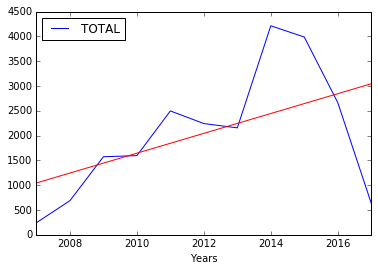

In [41]:
df_counts_pyear.plot(x="Years",y="TOTAL")
plt.plot(df_counts_pyear["Years"],slope*df_counts_pyear["Years"]+intercept,"-",color="red") 

# Without 2017

In [42]:
df_2007_2016 = df_counts_pyear[df_counts_pyear['Years'] != 2017]

In [43]:
lm = smf.ols(formula="TOTAL~Years",data=df_2007_2016).fit()

In [44]:
lm.params

Intercept   -723270.218182
Years           360.654545
dtype: float64

In [45]:
intercept, slope = lm.params

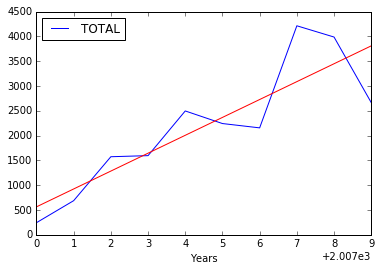

In [46]:
df_2007_2016.plot(x="Years",y="TOTAL")
plt.plot(df_2007_2016["Years"],slope*df_2007_2016["Years"]+intercept,"-",color="red")

In [47]:
df_2007_2016.to_csv('2007_2016_ziv_de.csv')

# Harmonising at Gerichtsschreiber

In [48]:
def harm(elem):
    try:
        elem = elem.replace('R.', 'R')
        elem = elem.split('.')[0].replace('Gerichtsschreiber ', '').replace('Gerichtsschreiberin ', '')
        return elem
    except:
        return elem

In [49]:
df_bools['Schreiberharm'] = df_bools['Gerichtsschreiber'].apply(harm)

In [50]:
df_bools['Schreiberharm'].value_counts().head()

Füllemann    3110
Huguenin      857
Zbinden       857
Möckli        612
Leemann       597
Name: Schreiberharm, dtype: int64

# Merging with large file to sort out Abgeschrieben/Nichteingetreten

In [51]:
df = pd.read_csv('data/df_final_harm.csv')
df = df[['Aktennummer', 'Entscheid_harm']].copy()
df_ = df_bools.merge(df, left_on='Aktennummer', right_on='Aktennummer')
df_ = df_[df_['Entscheid_harm'] != 'Nicht eingetreten']

# Working out, total by Clerk

In [52]:
df_totalelems = pd.DataFrame(df_.groupby('Schreiberharm')['TOTAL'].sum().sort_values(ascending=False))

# Working out number of appeals, we counted their involvement in

In [53]:
df = pd.read_csv('data/df_final_harm.csv')
df = df[df['Entscheid_harm'] != 'Nicht eingetreten']
df_sozrecht = df[df['recht_harm'] == 'Zivilrecht']
df_sozrecht = df_sozrecht[df_sozrecht['Language'] == 'De']

In [54]:
df_totalappeals = pd.DataFrame(df_sozrecht['Schreiber_harm'].value_counts())

# Merging total Elem Count with total Appeals by Clerk

In [55]:
df_final = df_totalelems.merge(df_totalappeals, how='left', left_index=True, right_index=True)

In [56]:
df_final.columns = [['ELEM 500 COUNT', 'TOTAL APPEALS']]
df_final['Elem pCase'] = round(df_final['ELEM 500 COUNT'] / df_final['TOTAL APPEALS'], 1)

In [57]:
df_final.sort_values(by='Elem pCase', ascending=False).head(30)

,ELEM 500 COUNT,TOTAL APPEALS,Elem pCase
Schreiberharm,,,
Schneuwly,57,7.0,8.1
Störi,8,1.0,8.0
Brugger,440,65.0,6.8
Füllemann,2698,518.0,5.2
Marti,188,85.0,2.2
Leemann,729,364.0,2.0
Kölz,270,149.0,1.8
Hürlimann,74,77.0,1.0
Reitze,139,143.0,1.0


# Gutheissungsquote nach Gerichtsschreiber

In [58]:
df_gut = pd.read_csv('data/schreiber_percent.csv')

In [59]:
df_gut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 6 columns):
Unnamed: 0             250 non-null int64
Abgewiesen %           250 non-null float64
Gutgeheissen %         250 non-null float64
Nicht eingetreten %    250 non-null float64
Schreiber              250 non-null object
Total                  250 non-null int64
dtypes: float64(3), int64(2), object(1)
memory usage: 11.8+ KB


In [60]:
df_gut = df_gut[['Schreiber', 'Gutgeheissen %']].copy()
def remove(elem):
    elem = elem.replace('.', '')
    return elem
df_gut['Schreiber'] = df_gut['Schreiber'].apply(remove)
df_gut.index = df_gut['Schreiber']
del df_gut['Schreiber']

# Merge with final df

In [61]:
df_final = df_final.merge(df_gut, how='left', left_index=True, right_index=True)

In [62]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58 entries, Füllemann to von RotenVerfahrensbeteiligte
Data columns (total 4 columns):
ELEM 500 COUNT    58 non-null int64
TOTAL APPEALS     48 non-null float64
Elem pCase        48 non-null float64
Gutgeheissen %    44 non-null float64
dtypes: float64(3), int64(1)
memory usage: 2.3+ KB


In [63]:
df_final.sort_values(by='Elem pCase', ascending=False).head(50)
df_final = df_final[df_final['TOTAL APPEALS'] > 50]

In [65]:
#df_final.drop('Monn', inplace=True)
#df_final.drop('Arquint Hill', inplace=True)

In [66]:
df_final.columns = [['ELEM 500 COUNT', 'TOTAL APPEALS', 'ElempCase', 'Gutgeheissen']]

# Is there a correlation between amout of copy pasted elements and the percentage of successful appeals?

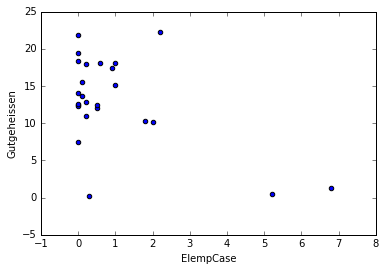

In [67]:
df_final.plot(kind='scatter', x='ElempCase', y='Gutgeheissen')

In [68]:
lm = smf.ols(formula="ElempCase~Gutgeheissen",data=df_final).fit()

In [69]:
intercept, slope = lm.params

In [70]:
lm.params

Intercept       2.896804
Gutgeheissen   -0.148933
dtype: float64

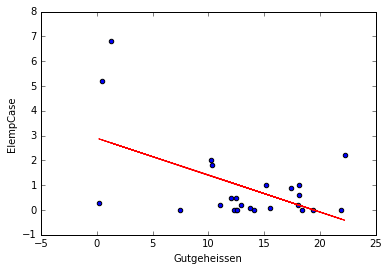

In [71]:
df_final.plot(kind='scatter', x="Gutgeheissen",y="ElempCase")
plt.plot(df_final["Gutgeheissen"],slope*df_final["Gutgeheissen"]+intercept,"-",color="red") 

In [72]:
df_final

,ELEM 500 COUNT,TOTAL APPEALS,ElempCase,Gutgeheissen
Schreiberharm,,,,
Füllemann,2698,518.0,5.2,0.5
Leemann,729,364.0,2.0,10.2
Brugger,440,65.0,6.8,1.3
Luczak,326,356.0,0.9,17.4
Kölz,270,149.0,1.8,10.3
Levante,197,314.0,0.6,18.1
Marti,188,85.0,2.2,22.2
Reitze,139,143.0,1.0,18.1
Hurni,110,243.0,0.5,12.0


In [73]:
df_final.to_csv('ziv_500_de.csv')

In [74]:
# Merge with french Data